## Import Libraries

In [1]:
import pandas as pd                                                         #import dataset
from sklearn.preprocessing import LabelEncoder                              #encode targets
from sklearn.model_selection import train_test_split                        #split dataset into train and test
from sklearn.metrics import roc_auc_score, log_loss, confusion_matrix       #metrics
import numpy as np                                                          #numpy operations                                     
import seaborn as sns                                                       #plotting
import matplotlib.pyplot as plt                                             #plotting
from scipy.sparse import hstack, vstack                                     #concatenation of features
import itertools                                                            #loop through hyperparameters
from sklearn.neighbors import KNeighborsClassifier                          #K Nearest Neighbors
from sklearn.linear_model import SGDClassifier                              #Logistic Regression, SVM
from sklearn.naive_bayes import MultinomialNB                               #Naive Bayes
from sklearn.ensemble import RandomForestClassifier                         #Random Forest
from sklearn.calibration import CalibratedClassifierCV                      #to get probabilities
import xgboost as xgb                                                       #XGBoost
from sklearn.model_selection import RandomizedSearchCV                      #Hyperparameter Tuning
from tqdm import tqdm                                                       #to track progress
from sklearn.preprocessing import Normalizer, StandardScaler                #standardizing
from sklearn.feature_extraction.text import TfidfVectorizer                 #TF IDF vectorizer
from prettytable import PrettyTable                                         #summarize results

## Data Import

In [2]:
df_noevents = pd.read_pickle("dataset/dataset_train_noevents.pkl")
df_events = pd.read_pickle("dataset/dataset_train_events.pkl")

In [6]:
tqdm.pandas()
df_noevents = df_noevents.progress_apply(release_bins, axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 51355/51355 [00:42<00:00, 1197.18it/s]


In [7]:
df_events = df_events.progress_apply(release_bins, axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 23290/23290 [00:19<00:00, 1193.48it/s]


## Data Cleaning

In [9]:
df_noevents.loc[df_noevents['specs_available']==0,'screen_size']=0
df_noevents.loc[df_noevents['specs_available']==0,'ram_gb']=0
df_noevents.loc[df_noevents['specs_available']==0,'camera']=0

In [10]:
df_events.loc[df_events['specs_available']==0,'screen_size']=0
df_events.loc[df_events['specs_available']==0,'ram_gb']=0
df_events.loc[df_events['specs_available']==0,'camera']=0
df_events.loc[df_events['app_usage'].isna(),'app_usage']=0
df_events.loc[df_events['app_usage_session'].isna(),'app_usage_session']=0

### Splitting into Train, Cross-Validate and Test Sets

In [14]:
df_noevents_data, df_noevents_test = train_test_split(df_noevents, test_size = 0.2)
df_noevents_train, df_noevents_cv = train_test_split(df_noevents_data, test_size = 0.2)

In [15]:
df_events_data, df_events_test = train_test_split(df_events, test_size = 0.2)
df_events_train, df_events_cv = train_test_split(df_events_data, test_size = 0.2)

In [16]:
print(df_noevents_train.shape, df_noevents_cv.shape, df_noevents_test.shape)
print(df_events_train.shape, df_events_cv.shape, df_events_test.shape)

(32867, 11) (8217, 11) (10271, 11)
(14905, 24) (3727, 24) (4658, 24)


In [17]:
print(df_noevents_train.columns)
print(df_events_train.columns)

Index(['device_id', 'brand', 'model', 'gender', 'age', 'group', 'screen_size',
       'ram_gb', 'camera', 'specs_available', 'release_bin'],
      dtype='object')
Index(['device_id', 'brand', 'model', 'gender', 'age', 'group', 'app_usage',
       'app_usage_session', 'active_app_usage_counts', 'activity_hour',
       'activity_day', 'num_travels', 'mean_latitude', 'mean_longitude',
       'screen_size', 'ram_gb', 'camera', 'installed_app_labels',
       'active_app_labels', 'installed_app_counts', 'active_app_usage',
       'location_available', 'specs_available', 'release_bin'],
      dtype='object')


## Utility Functions

In [40]:
def hyperparameter_tuning(classifier, hp_list, hp, X_train, y_train, X_cv, y_cv, X_test, y_test):
    """Function to perform Hyperparameter tuning of the models. Takes the model name, hyperparameter name and list 
    along with the train, cross validation and test datasets as input"""
    
    #stores the losses
    cv_log_error_array = []
    
    #https://stackoverflow.com/questions/32438350/python-merging-two-lists-with-all-possible-permutations/32438848
    if classifier == "rf":
        hp_list = list(itertools.product(hp_list[0], hp_list[1]))
    
    for i in hp_list:
        
        if classifier == "rf":
            #since random forest has two hyperparameters
            print("for n_estimators = {}, max_depth = {}".format(i[0],i[1]))
        else:
            print("for {} = {}".format(hp,i))
        
        #initialize the classifier with the hyperparameter
        if classifier == "nb":
            clf = MultinomialNB(alpha=i)
        elif classifier == "knn":
            clf = KNeighborsClassifier(n_neighbors=i)
        elif classifier == "lrb":
            clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
        elif classifier == "lr":
            clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
        elif classifier == "svm":
            clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
        elif classifier == "rf":
            clf = RandomForestClassifier(n_estimators=i[0], criterion='gini', max_depth=i[1], random_state=42, n_jobs=-1)
        
        #fit and train the model
        clf.fit(X_train, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train, y_train)
        sig_clf_probs = sig_clf.predict_proba(X_cv)
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        
        # to avoid rounding error while multiplying probabilites we use log-probability estimates
        print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

    #select the hyperparameter with the best performance metric
    best_hp = np.argmin(cv_log_error_array)
    
    #retraining with the best hyperparameter
    if classifier == "nb":
        clf = MultinomialNB(alpha=hp_list[best_hp])
    elif classifier == "knn":
        clf = KNeighborsClassifier(n_neighbors=hp_list[best_hp])
    elif classifier == "lrb":
        clf = SGDClassifier(class_weight='balanced', alpha=hp_list[best_hp], penalty='l2', loss='log', random_state=42)
    elif classifier == "lr":
        clf = SGDClassifier(alpha=hp_list[best_hp], penalty='l2', loss='log', random_state=42)
    elif classifier == "svm":
        clf = SGDClassifier(class_weight='balanced', alpha=hp_list[best_hp], penalty='l2', loss='hinge', random_state=42)
    elif classifier == "rf":
        clf = RandomForestClassifier(n_estimators=hp_list[best_hp][0], criterion='gini', max_depth=hp_list[best_hp][1], random_state=42, n_jobs=-1)
    
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    
    #getting train, cross validation and test log loss
    predict_y = sig_clf.predict_proba(X_train)
    train_loss = log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)
    print('For values of best ',hp,' = ', hp_list[best_hp], "The train log loss is:", train_loss)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_loss = log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)
    print('For values of best ',hp,' = ', hp_list[best_hp], "The cross validation log loss is:", cv_loss)
    predict_y = sig_clf.predict_proba(X_test)
    test_loss = log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)
    print('For values of best ',hp,' = ', hp_list[best_hp], "The test log loss is:", test_loss)
    
    #number of misclassified records
    mp = np.count_nonzero((sig_clf.predict(X_test)- y_test))/y_test.shape[0]
    print("Percentage of missclassified points :", mp)
    
    #accuracy
    acc = (1-mp)*100
    print("Accuracy: ", acc)
    
    predicted_y =np.argmax(predict_y, axis=1)
    
    #AUC
    auc = roc_auc_score(y_test, predict_y[:,1])
    print("AUC: ", auc)
    
    plot_confusion_matrix(y_test, predicted_y)
    
    return acc, auc, test_loss

In [37]:
def plot_confusion_matrix(test_y, predict_y):
    """Function to plot the confusion matrix. Takes ground truth and predicttions as input parameters"""
    
    #confusion matrix values
    C = confusion_matrix(test_y, predict_y)
    
    #recall matrix values
    A =(((C.T)/(C.sum(axis=1))).T)
    
    #precision matrix values
    B =(C/C.sum(axis=0))
    
    #drawing the canvas
    plt.figure(figsize=(15,3))
    
    #number of labels/classes. Since each context has 10 sentences at the max, 10 classes
    labels = ['F','M']
    
    # plotting confusion matrix
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    # plotting precision matrix
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    # plotting recall matrix
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## No Events

### Feature Variables

In [20]:
noevents_brand_encoder = TfidfVectorizer()

noevents_brand_train = noevents_brand_encoder.fit_transform(df_noevents_train['brand'])
noevents_brand_cv = noevents_brand_encoder.transform(df_noevents_cv['brand'])
noevents_brand_test = noevents_brand_encoder.transform(df_noevents_test['brand'])

In [21]:
noevents_model_encoder = TfidfVectorizer()

noevents_model_train = noevents_model_encoder.fit_transform(df_noevents_train['model'])
noevents_model_cv = noevents_model_encoder.transform(df_noevents_cv['model'])
noevents_model_test = noevents_model_encoder.transform(df_noevents_test['model'])

In [22]:
noevents_x_train = hstack((noevents_brand_train, noevents_model_train))
noevents_x_cv = hstack((noevents_brand_cv, noevents_model_cv))
noevents_x_test = hstack((noevents_brand_test, noevents_model_test))

### Target Variables

In [23]:
noevents_y_encoder = LabelEncoder()

noevents_y_train = noevents_y_encoder.fit_transform(df_noevents_train['gender'])
noevents_y_cv = noevents_y_encoder.transform(df_noevents_cv['gender'])
noevents_y_test = noevents_y_encoder.transform(df_noevents_test['gender'])

## Random Model

Log loss on Test Data using Random Model 0.8802070835673116
Percentage of missclassified point : 0.496251582124428
Accuracy:  50.3748417875572
AUC:  0.5080703958423932


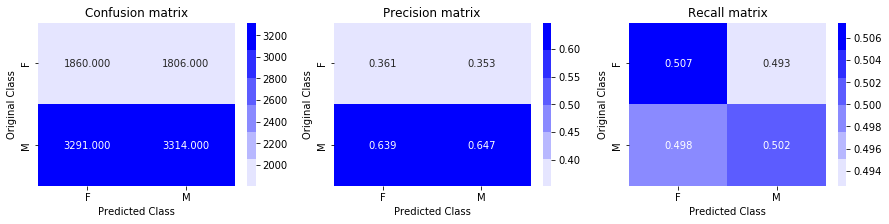

In [38]:
noevents_model_rand = "No Events - Random Model"

predicted_y = np.zeros((len(noevents_y_test),2))
for i in range(len(noevents_y_test)):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])

noevents_logloss_rand = log_loss(noevents_y_test, predicted_y, labels = list(range(2)), eps=1e-15)
print("Log loss on Test Data using Random Model", noevents_logloss_rand)

predict_y =np.argmax(predicted_y, axis=1)
mp = np.count_nonzero((predict_y- noevents_y_test))/noevents_y_test.shape[0]
print("Percentage of missclassified point :", mp)
noevents_acc_rand = (1-mp)*100
print("Accuracy: ", noevents_acc_rand)

noevents_auc_rand = roc_auc_score(noevents_y_test, predicted_y[:,1])
print("AUC: ", noevents_auc_rand)

plot_confusion_matrix(noevents_y_test, predict_y)

## Logistic Regression Model with Balanced Class Weights

for alpha = 1e-06
Log Loss : 0.6505336545272709
for alpha = 1e-05
Log Loss : 0.6489301586177119
for alpha = 0.0001
Log Loss : 0.6466495227961564
for alpha = 0.001
Log Loss : 0.6465041029616588
for alpha = 0.01
Log Loss : 0.6493419922769229
for alpha = 0.1
Log Loss : 0.6516081751010573
for alpha = 1
Log Loss : 0.6524068519592795
for alpha = 10
Log Loss : 0.6525079586202323
for alpha = 100
Log Loss : 0.6525190318222682
For values of best  alpha  =  0.001 The train log loss is: 0.6443222298773212
For values of best  alpha  =  0.001 The cross validation log loss is: 0.6465041029616588
For values of best  alpha  =  0.001 The test log loss is: 0.6431217313159853
Percentage of missclassified points : 0.3541037873624769
Accuracy:  64.58962126375232
AUC:  0.574866326944862


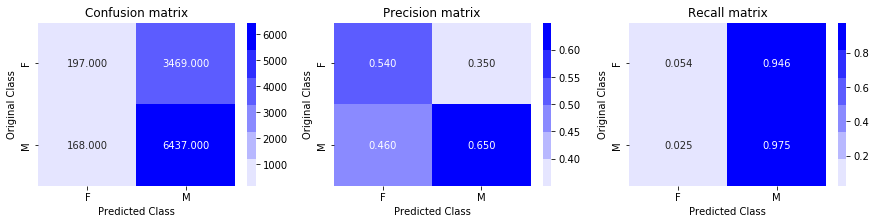

In [42]:
noevents_model_lrb = "No Events - Logistic Regression Balanced"

alpha = [10 ** x for x in range(-6, 3)]

noevents_acc_lrb, noevents_auc_lrb, noevents_logloss_lrb = hyperparameter_tuning("lrb", alpha, "alpha", noevents_x_train, noevents_y_train, noevents_x_cv, noevents_y_cv, noevents_x_test, noevents_y_test)

## Support Vector Machines Model

for c = 1e-05
Log Loss : 0.6488937988580705
for c = 0.0001
Log Loss : 0.6478783278137864
for c = 0.001
Log Loss : 0.6492088989085321
for c = 0.01
Log Loss : 0.6513382361789744
for c = 0.1
Log Loss : 0.6525223744723115
for c = 1
Log Loss : 0.6525215733455157
for c = 10
Log Loss : 0.6525215733454811
for c = 100
Log Loss : 0.6525215733455756
For values of best  c  =  0.0001 The train log loss is: 0.6430289108050629
For values of best  c  =  0.0001 The cross validation log loss is: 0.6478783278137864
For values of best  c  =  0.0001 The test log loss is: 0.6442300287380124
Percentage of missclassified points : 0.35692727095706356
Accuracy:  64.30727290429364
AUC:  0.5749522279117847


C:\Users\ADMIN\Anaconda3\envs\appliedai\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


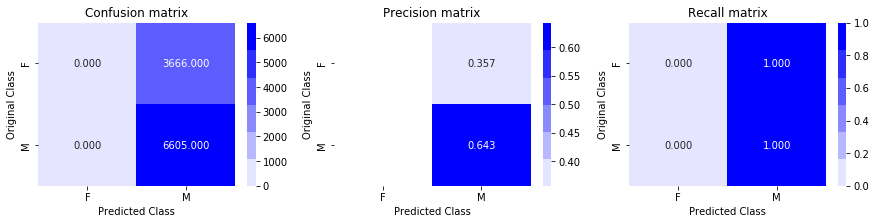

In [43]:
noevents_model_svm = "No Events - Support Vector Machines"

c = [10 ** x for x in range(-5, 3)]

noevents_acc_svm, noevents_auc_svm, noevents_logloss_svm = hyperparameter_tuning("svm", c, "c", noevents_x_train, noevents_y_train, noevents_x_cv, noevents_y_cv, noevents_x_test, noevents_y_test)

## Random Forest Model

for n_estimators = 100, max_depth = 5
Log Loss : 0.648730485436175
for n_estimators = 100, max_depth = 10
Log Loss : 0.6486965239717835
for n_estimators = 200, max_depth = 5
Log Loss : 0.6486686948629407
for n_estimators = 200, max_depth = 10
Log Loss : 0.6484782542040891
for n_estimators = 500, max_depth = 5
Log Loss : 0.6488681683006732
for n_estimators = 500, max_depth = 10
Log Loss : 0.6483661247438516
for n_estimators = 1000, max_depth = 5
Log Loss : 0.6489606944079798
for n_estimators = 1000, max_depth = 10
Log Loss : 0.6484279754605314
for n_estimators = 2000, max_depth = 5
Log Loss : 0.6488574957704166
for n_estimators = 2000, max_depth = 10
Log Loss : 0.6484051172417304
For values of best  n_estimator, max_depth  =  (500, 10) The train log loss is: 0.6446147553896424
For values of best  n_estimator, max_depth  =  (500, 10) The cross validation log loss is: 0.6483661247438516
For values of best  n_estimator, max_depth  =  (500, 10) The test log loss is: 0.6433900426382536
Perce

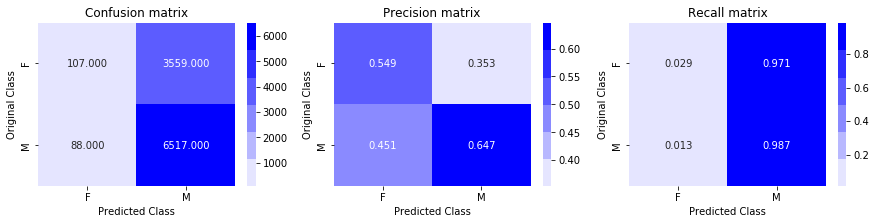

In [44]:
noevents_model_rf = "No Events - Random Forest"

n_estimator = [100,200,500,1000,2000]
max_depth = [5, 10]

hp = [n_estimator, max_depth]

noevents_acc_rf, noevents_auc_rf, noevents_logloss_rf = hyperparameter_tuning("rf", hp, "n_estimator, max_depth", noevents_x_train, noevents_y_train, noevents_x_cv, noevents_y_cv, noevents_x_test, noevents_y_test)

## XGBoost Model

Fitting 2 folds for each of 30 candidates, totalling 60 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  35 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:    4.4s finished


The test log loss is: 0.649878442548589
Percentage of missclassified point : 0.35313017232986077
Accuracy:  64.68698276701392
AUC:  0.5710925487931947


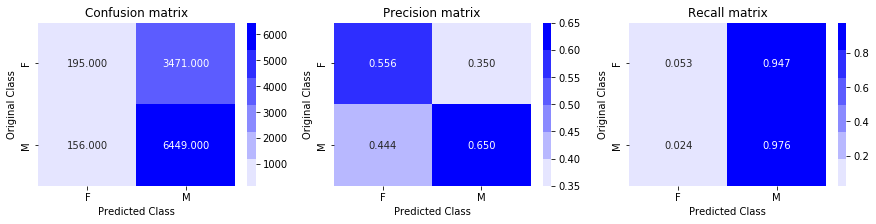

In [46]:
noevents_model_xgb = "No Events - XGBoost"

params = {
         'eval_metric':['logloss'],
         'eta':[0.02, 0.01, 0.1, 0.5],
         'max_depth':[4,6,8,10],
         'n_estimators':[5,10,20,50,100]
         }

clf = xgb.XGBClassifier(objective='binary:logistic')

x = vstack((noevents_x_train, noevents_x_cv))
y = np.concatenate([noevents_y_train, noevents_y_cv])

#trying out 30 possible combinations of hyperparameters
rs_clf = RandomizedSearchCV(clf, params, verbose = 2, cv = 2, n_iter = 30, n_jobs = 8)
rs_clf.fit(x,y)

best_clf = rs_clf.best_estimator_

predict_y_proba = best_clf.predict_proba(noevents_x_test)
predict_y = best_clf.predict(noevents_x_test)
noevents_logloss_xgb = log_loss(noevents_y_test, predict_y_proba, labels=best_clf.classes_, eps=1e-15)
print("The test log loss is:",noevents_logloss_xgb)

mp = np.count_nonzero((predict_y- noevents_y_test))/noevents_y_test.shape[0]
print("Percentage of missclassified point :", mp)

noevents_acc_xgb = (1-mp)*100
print("Accuracy: ", noevents_acc_xgb)

noevents_auc_xgb = roc_auc_score(noevents_y_test, predict_y_proba[:,1])
print("AUC: ", noevents_auc_xgb) 

plot_confusion_matrix(noevents_y_test, predict_y)

## Results for records without events

In [47]:
#summarizing results
from prettytable import PrettyTable

table = PrettyTable()

table.field_names = ["Model", "Accuracy", "AUC", "LogLoss"]

table.add_row([noevents_model_rand, noevents_acc_rand, noevents_auc_rand, noevents_logloss_rand])
table.add_row([noevents_model_lrb, noevents_acc_lrb, noevents_auc_lrb, noevents_logloss_lrb])
table.add_row([noevents_model_svm, noevents_acc_svm, noevents_auc_svm, noevents_logloss_svm])
table.add_row([noevents_model_rf, noevents_acc_rf, noevents_auc_rf, noevents_logloss_rf])
table.add_row([noevents_model_xgb, noevents_acc_xgb, noevents_auc_xgb, noevents_logloss_xgb])

print(table)

+------------------------------------------+-------------------+--------------------+--------------------+
|                  Model                   |      Accuracy     |        AUC         |      LogLoss       |
+------------------------------------------+-------------------+--------------------+--------------------+
|         No Events - Random Model         |  50.3748417875572 | 0.5080703958423932 | 0.8802070835673116 |
| No Events - Logistic Regression Balanced | 64.58962126375232 | 0.574866326944862  | 0.6431217313159853 |
|   No Events - Support Vector Machines    | 64.30727290429364 | 0.5749522279117847 | 0.6442300287380124 |
|        No Events - Random Forest         |  64.4922597604907 | 0.5727238618431623 | 0.6433900426382536 |
|           No Events - XGBoost            | 64.68698276701392 | 0.5710925487931947 | 0.649878442548589  |
+------------------------------------------+-------------------+--------------------+--------------------+


## Including device specifications

In [48]:
scaler = StandardScaler()

In [49]:
noevents_screen_train = scaler.fit_transform(df_noevents_train['screen_size'].values.reshape(-1,1))
noevents_screen_cv = scaler.transform(df_noevents_cv['screen_size'].values.reshape(-1,1))
noevents_screen_test = scaler.transform(df_noevents_test['screen_size'].values.reshape(-1,1))

In [50]:
noevents_ram_train = scaler.fit_transform(df_noevents_train['ram_gb'].values.reshape(-1,1))
noevents_ram_cv = scaler.transform(df_noevents_cv['ram_gb'].values.reshape(-1,1))
noevents_ram_test = scaler.transform(df_noevents_test['ram_gb'].values.reshape(-1,1))

In [51]:
noevents_camera_train = scaler.fit_transform(df_noevents_train['camera'].values.reshape(-1,1))
noevents_camera_cv = scaler.transform(df_noevents_cv['camera'].values.reshape(-1,1))
noevents_camera_test = scaler.transform(df_noevents_test['camera'].values.reshape(-1,1))

In [52]:
noevents_release_train = scaler.fit_transform(df_noevents_train['release_bin'].values.reshape(-1,1))
noevents_release_cv = scaler.transform(df_noevents_cv['release_bin'].values.reshape(-1,1))
noevents_release_test = scaler.transform(df_noevents_test['release_bin'].values.reshape(-1,1))

In [53]:
noevents_x_train = hstack((noevents_brand_train, noevents_model_train, noevents_screen_train, noevents_ram_train, 
                           noevents_camera_train, noevents_release_train, df_noevents_train['specs_available'].values.reshape(-1,1)))
noevents_x_cv = hstack((noevents_brand_cv, noevents_model_cv, noevents_screen_cv, noevents_ram_cv,
                        noevents_camera_cv, noevents_release_cv, df_noevents_cv['specs_available'].values.reshape(-1,1)))
noevents_x_test = hstack((noevents_brand_test, noevents_model_test, noevents_screen_test, noevents_ram_test,
                          noevents_camera_test, noevents_release_test, df_noevents_test['specs_available'].values.reshape(-1,1)))

## Logistic Regression Model with Balanced Class Weights

for alpha = 1e-06
Log Loss : 0.6509337389198093
for alpha = 1e-05
Log Loss : 0.648256336119244
for alpha = 0.0001
Log Loss : 0.6466418440989202
for alpha = 0.001
Log Loss : 0.6465663927187774
for alpha = 0.01
Log Loss : 0.6484096343220772
for alpha = 0.1
Log Loss : 0.651165640248387
for alpha = 1
Log Loss : 0.6523190846457683
for alpha = 10
Log Loss : 0.6526504236682922
for alpha = 100
Log Loss : 0.6527000261754984
For values of best  alpha  =  0.001 The train log loss is: 0.6443617049610587
For values of best  alpha  =  0.001 The cross validation log loss is: 0.6465663927187774
For values of best  alpha  =  0.001 The test log loss is: 0.6431428582895486
Percentage of missclassified points : 0.35478531788530815
Accuracy:  64.52146821146918
AUC:  0.5767198261496584


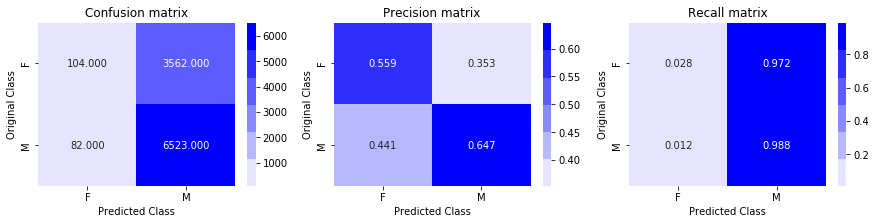

In [54]:
noevents_model_lrb = "No Events - Logistic Regression Balanced"

alpha = [10 ** x for x in range(-6, 3)]

noevents_acc_lrb, noevents_auc_lrb, noevents_logloss_lrb = hyperparameter_tuning("lrb", alpha, "alpha", noevents_x_train, noevents_y_train, noevents_x_cv, noevents_y_cv, noevents_x_test, noevents_y_test)

## Support Vector Machines Model

for c = 1e-05
Log Loss : 0.6478948291082713
for c = 0.0001
Log Loss : 0.6477416574320422
for c = 0.001
Log Loss : 0.6487266039628535
for c = 0.01
Log Loss : 0.650579058625441
for c = 0.1
Log Loss : 0.6525977694256516
for c = 1
Log Loss : 0.652699195670909
for c = 10
Log Loss : 0.6527006519828403
for c = 100
Log Loss : 0.6527006519577838
For values of best  c  =  0.0001 The train log loss is: 0.6427249483403825
For values of best  c  =  0.0001 The cross validation log loss is: 0.6477416574320422
For values of best  c  =  0.0001 The test log loss is: 0.6437678171553595
Percentage of missclassified points : 0.35692727095706356
Accuracy:  64.30727290429364
AUC:  0.5769475876076292


C:\Users\ADMIN\Anaconda3\envs\appliedai\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


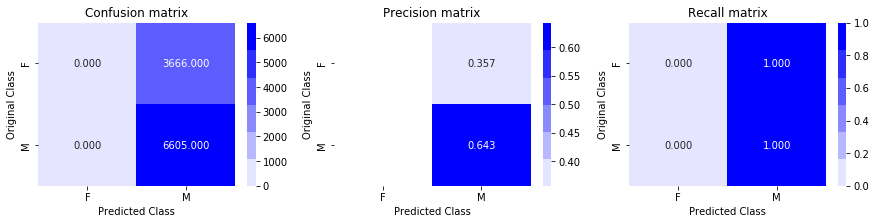

In [55]:
noevents_model_svm = "No Events - Support Vector Machines"

c = [10 ** x for x in range(-5, 3)]

noevents_acc_svm, noevents_auc_svm, noevents_logloss_svm = hyperparameter_tuning("svm", c, "c", noevents_x_train, noevents_y_train, noevents_x_cv, noevents_y_cv, noevents_x_test, noevents_y_test)

## Random Forest Model

for n_estimators = 100, max_depth = 5
Log Loss : 0.6483059518272751
for n_estimators = 100, max_depth = 10
Log Loss : 0.6471526015901011
for n_estimators = 200, max_depth = 5
Log Loss : 0.6482450985424266
for n_estimators = 200, max_depth = 10
Log Loss : 0.6474295104600133
for n_estimators = 500, max_depth = 5
Log Loss : 0.6480323856951223
for n_estimators = 500, max_depth = 10
Log Loss : 0.6474826315898619
for n_estimators = 1000, max_depth = 5
Log Loss : 0.6481317285577348
for n_estimators = 1000, max_depth = 10
Log Loss : 0.6475443229437496
for n_estimators = 2000, max_depth = 5
Log Loss : 0.6479832943437204
for n_estimators = 2000, max_depth = 10
Log Loss : 0.6474983940402734
For values of best  n_estimator, max_depth  =  (100, 10) The train log loss is: 0.6428637580562635
For values of best  n_estimator, max_depth  =  (100, 10) The cross validation log loss is: 0.6471526015901011
For values of best  n_estimator, max_depth  =  (100, 10) The test log loss is: 0.6422951822965546
Perc

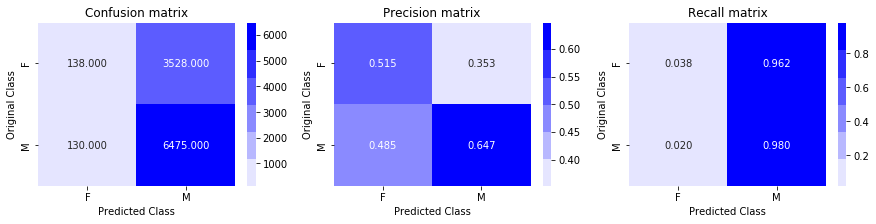

In [56]:
noevents_model_rf = "No Events - Random Forest"

n_estimator = [100,200,500,1000,2000]
max_depth = [5, 10]

hp = [n_estimator, max_depth]

noevents_acc_rf, noevents_auc_rf, noevents_logloss_rf = hyperparameter_tuning("rf", hp, "n_estimator, max_depth", noevents_x_train, noevents_y_train, noevents_x_cv, noevents_y_cv, noevents_x_test, noevents_y_test)

## XGBoost Model

Fitting 2 folds for each of 30 candidates, totalling 60 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:   10.2s finished


The test log loss is: 0.642795016830068
Percentage of missclassified point : 0.3532275338331224
Accuracy:  64.67724661668777
AUC:  0.5832082606995229


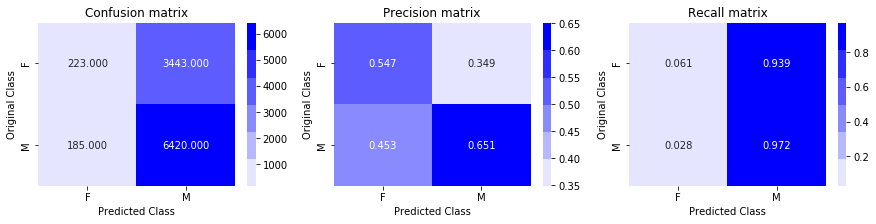

In [57]:
noevents_model_xgb = "No Events - XGBoost"

params = {
         'eval_metric':['logloss'],
         'eta':[0.02, 0.01, 0.1, 0.5],
         'max_depth':[4,6,8,10],
         'n_estimators':[5,10,20,50,100]
         }

clf = xgb.XGBClassifier(objective='binary:logistic')

x = vstack((noevents_x_train, noevents_x_cv))
y = np.concatenate([noevents_y_train, noevents_y_cv])

#trying out 30 possible combinations of hyperparameters
rs_clf = RandomizedSearchCV(clf, params, verbose = 2, cv = 2, n_iter = 30, n_jobs = 8)
rs_clf.fit(x,y)

best_clf = rs_clf.best_estimator_

predict_y_proba = best_clf.predict_proba(noevents_x_test)
predict_y = best_clf.predict(noevents_x_test)
noevents_logloss_xgb = log_loss(noevents_y_test, predict_y_proba, labels=best_clf.classes_, eps=1e-15)
print("The test log loss is:",noevents_logloss_xgb)

mp = np.count_nonzero((predict_y- noevents_y_test))/noevents_y_test.shape[0]
print("Percentage of missclassified point :", mp)

noevents_acc_xgb = (1-mp)*100
print("Accuracy: ", noevents_acc_xgb)

noevents_auc_xgb = roc_auc_score(noevents_y_test, predict_y_proba[:,1])
print("AUC: ", noevents_auc_xgb) 

plot_confusion_matrix(noevents_y_test, predict_y)

## Results for records without events

In [58]:
#summarizing results
from prettytable import PrettyTable

table = PrettyTable()

table.field_names = ["Model", "Accuracy", "AUC", "LogLoss"]

table.add_row([noevents_model_rand, noevents_acc_rand, noevents_auc_rand, noevents_logloss_rand])
table.add_row([noevents_model_lrb, noevents_acc_lrb, noevents_auc_lrb, noevents_logloss_lrb])
table.add_row([noevents_model_svm, noevents_acc_svm, noevents_auc_svm, noevents_logloss_svm])
table.add_row([noevents_model_rf, noevents_acc_rf, noevents_auc_rf, noevents_logloss_rf])
table.add_row([noevents_model_xgb, noevents_acc_xgb, noevents_auc_xgb, noevents_logloss_xgb])

print(table)

+------------------------------------------+-------------------+--------------------+--------------------+
|                  Model                   |      Accuracy     |        AUC         |      LogLoss       |
+------------------------------------------+-------------------+--------------------+--------------------+
|         No Events - Random Model         |  50.3748417875572 | 0.5080703958423932 | 0.8802070835673116 |
| No Events - Logistic Regression Balanced | 64.52146821146918 | 0.5767198261496584 | 0.6431428582895486 |
|   No Events - Support Vector Machines    | 64.30727290429364 | 0.5769475876076292 | 0.6437678171553595 |
|        No Events - Random Forest         | 64.38516210690292 | 0.5807111650194743 | 0.6422951822965546 |
|           No Events - XGBoost            | 64.67724661668777 | 0.5832082606995229 | 0.642795016830068  |
+------------------------------------------+-------------------+--------------------+--------------------+


## With Events

In [62]:
print(df_events_train.columns)

Index(['device_id', 'brand', 'model', 'gender', 'age', 'group', 'app_usage',
       'app_usage_session', 'active_app_usage_counts', 'activity_hour',
       'activity_day', 'num_travels', 'mean_latitude', 'mean_longitude',
       'screen_size', 'ram_gb', 'camera', 'installed_app_labels',
       'active_app_labels', 'installed_app_counts', 'active_app_usage',
       'location_available', 'specs_available', 'release_bin'],
      dtype='object')


In [63]:
events_brand_encoder = TfidfVectorizer()

events_brand_train = events_brand_encoder.fit_transform(df_events_train['brand'])
events_brand_cv = events_brand_encoder.transform(df_events_cv['brand'])
events_brand_test = events_brand_encoder.transform(df_events_test['brand'])

In [64]:
events_model_encoder = TfidfVectorizer()

events_model_train = events_model_encoder.fit_transform(df_events_train['model'])
events_model_cv = events_model_encoder.transform(df_events_cv['model'])
events_model_test = events_model_encoder.transform(df_events_test['model'])

In [65]:
events_active_labels_encoder = TfidfVectorizer()

events_active_labels_train = events_active_labels_encoder.fit_transform(df_events_train['active_app_labels'])
events_active_labels_cv = events_active_labels_encoder.transform(df_events_cv['active_app_labels'])
events_active_labels_test = events_active_labels_encoder.transform(df_events_test['active_app_labels'])

In [66]:
events_installed_labels_encoder = TfidfVectorizer()

events_installed_labels_train = events_installed_labels_encoder.fit_transform(df_events_train['installed_app_labels'])
events_installed_labels_cv = events_installed_labels_encoder.transform(df_events_cv['installed_app_labels'])
events_installed_labels_test = events_installed_labels_encoder.transform(df_events_test['installed_app_labels'])

In [67]:
scaler = StandardScaler()

In [71]:
events_lat_train = scaler.fit_transform(df_events_train['mean_latitude'].values.reshape(-1,1))
events_lat_cv = scaler.transform(df_events_cv['mean_latitude'].values.reshape(-1,1))
events_lat_test = scaler.transform(df_events_test['mean_latitude'].values.reshape(-1,1))

In [72]:
events_long_train = scaler.fit_transform(df_events_train['mean_longitude'].values.reshape(-1,1))
events_long_cv = scaler.transform(df_events_cv['mean_longitude'].values.reshape(-1,1))
events_long_test = scaler.transform(df_events_test['mean_longitude'].values.reshape(-1,1))

In [73]:
events_travels_train = scaler.fit_transform(df_events_train['num_travels'].values.reshape(-1,1))
events_travels_cv = scaler.transform(df_events_cv['num_travels'].values.reshape(-1,1))
events_travels_test = scaler.transform(df_events_test['num_travels'].values.reshape(-1,1))

In [84]:
events_x_train = hstack((events_brand_train, events_model_train, events_installed_labels_train, events_active_labels_train,
                         events_lat_train, events_long_train, events_travels_train, df_events_train['location_available'].values.reshape(-1,1), 
                         np.array(df_events_train['activity_hour'].to_list()), np.array(df_events_train['activity_day'].to_list()), 
                         df_events_train['app_usage'].values.reshape(-1,1), df_events_train['app_usage_session'].values.reshape(-1,1), 
                         np.array(df_events_train['installed_app_counts'].to_list()), np.array(df_events_train['active_app_usage_counts'].to_list()), 
                         np.array(df_events_train['active_app_usage'].to_list())))

In [85]:
events_x_cv = hstack((events_brand_cv, events_model_cv, events_installed_labels_cv, events_active_labels_cv,
                         events_lat_cv, events_long_cv, events_travels_cv, df_events_cv['location_available'].values.reshape(-1,1), 
                         np.array(df_events_cv['activity_hour'].to_list()), np.array(df_events_cv['activity_day'].to_list()), 
                         df_events_cv['app_usage'].values.reshape(-1,1), df_events_cv['app_usage_session'].values.reshape(-1,1), 
                         np.array(df_events_cv['installed_app_counts'].to_list()), np.array(df_events_cv['active_app_usage_counts'].to_list()), 
                         np.array(df_events_cv['active_app_usage'].to_list())))

In [86]:
events_x_test = hstack((events_brand_test, events_model_test, events_installed_labels_test, events_active_labels_test,
                         events_lat_test, events_long_test, events_travels_test, df_events_test['location_available'].values.reshape(-1,1), 
                         np.array(df_events_test['activity_hour'].to_list()), np.array(df_events_test['activity_day'].to_list()), 
                         df_events_test['app_usage'].values.reshape(-1,1), df_events_test['app_usage_session'].values.reshape(-1,1), 
                         np.array(df_events_test['installed_app_counts'].to_list()), np.array(df_events_test['active_app_usage_counts'].to_list()), 
                         np.array(df_events_test['active_app_usage'].to_list())))

### Target Variables

In [87]:
events_y_encoder = LabelEncoder()

events_y_train = events_y_encoder.fit_transform(df_events_train['gender'])
events_y_cv = events_y_encoder.transform(df_events_cv['gender'])
events_y_test = events_y_encoder.transform(df_events_test['gender'])

## Random Model

Log loss on Test Data using Random Model 0.8880323659542394
Percentage of missclassified point : 0.5008587376556461
Accuracy:  49.914126234435386
AUC:  0.5012614819350888


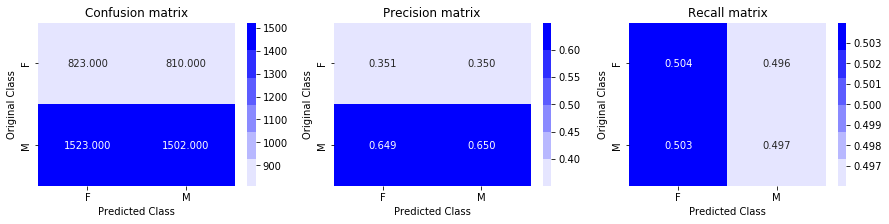

In [91]:
events_model_rand = "Events - Random Model"

predicted_y = np.zeros((len(events_y_test),2))
for i in range(len(events_y_test)):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])

events_logloss_rand = log_loss(events_y_test, predicted_y, labels = list(range(2)), eps=1e-15)
print("Log loss on Test Data using Random Model", events_logloss_rand)

predict_y =np.argmax(predicted_y, axis=1)
mp = np.count_nonzero((predict_y- events_y_test))/events_y_test.shape[0]
print("Percentage of missclassified point :", mp)
events_acc_rand = (1-mp)*100
print("Accuracy: ", events_acc_rand)

events_auc_rand = roc_auc_score(events_y_test, predicted_y[:,1])
print("AUC: ", events_auc_rand)

plot_confusion_matrix(events_y_test, predict_y)

## Logistic Regression Model with Balanced Class Weights

for alpha = 1e-06
Log Loss : 0.5882998935135769
for alpha = 1e-05
Log Loss : 0.5720844826097352
for alpha = 0.0001
Log Loss : 0.5472423250415698
for alpha = 0.001
Log Loss : 0.5465222231676108
for alpha = 0.01
Log Loss : 0.5638315589662249
for alpha = 0.1
Log Loss : 0.5948037606519968
for alpha = 1
Log Loss : 0.6200330795808037
for alpha = 10
Log Loss : 0.6257186655889829
for alpha = 100
Log Loss : 0.6263748360417437
For values of best  alpha  =  0.001 The train log loss is: 0.5056839491659889
For values of best  alpha  =  0.001 The cross validation log loss is: 0.5465222231676108
For values of best  alpha  =  0.001 The test log loss is: 0.5280133257535259
Percentage of missclassified points : 0.2608415629025333
Accuracy:  73.91584370974667
AUC:  0.7872894282692201


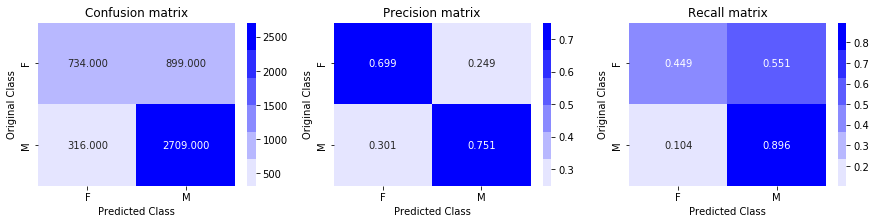

In [92]:
events_model_lrb = "Events - Logistic Regression Balanced"

alpha = [10 ** x for x in range(-6, 3)]

events_acc_lrb, events_auc_lrb, events_logloss_lrb = hyperparameter_tuning("lrb", alpha, "alpha", events_x_train, events_y_train, events_x_cv, events_y_cv, events_x_test, events_y_test)

## Support Vector Machines Model

for c = 1e-05
Log Loss : 0.5738034374597055
for c = 0.0001
Log Loss : 0.5506879985281838
for c = 0.001
Log Loss : 0.5460232153110046
for c = 0.01
Log Loss : 0.5615070016871105
for c = 0.1
Log Loss : 0.6024584903974415
for c = 1
Log Loss : 0.6264954504980393
for c = 10
Log Loss : 0.6264917889999514
for c = 100
Log Loss : 0.6264920502136134
For values of best  c  =  0.001 The train log loss is: 0.49675182332544054
For values of best  c  =  0.001 The cross validation log loss is: 0.5460232153110046
For values of best  c  =  0.001 The test log loss is: 0.5257974960513053
Percentage of missclassified points : 0.25697724345212536
Accuracy:  74.30227565478746
AUC:  0.7912219562433892


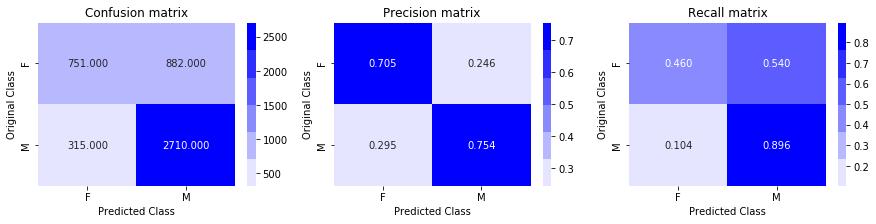

In [93]:
events_model_svm = "Events - Support Vector Machines"

c = [10 ** x for x in range(-5, 3)]

events_acc_svm, events_auc_svm, events_logloss_svm = hyperparameter_tuning("svm", c, "c", events_x_train, events_y_train, events_x_cv, events_y_cv, events_x_test, events_y_test)

## Random Forest Model

for n_estimators = 100, max_depth = 5
Log Loss : 0.5687573434370442
for n_estimators = 100, max_depth = 10
Log Loss : 0.5516839127760814
for n_estimators = 200, max_depth = 5
Log Loss : 0.5677929809927218
for n_estimators = 200, max_depth = 10
Log Loss : 0.5522350570096686
for n_estimators = 500, max_depth = 5
Log Loss : 0.5669498846275429
for n_estimators = 500, max_depth = 10
Log Loss : 0.5517570237028778
for n_estimators = 1000, max_depth = 5
Log Loss : 0.566386836227565
for n_estimators = 1000, max_depth = 10
Log Loss : 0.5512805495401437
for n_estimators = 2000, max_depth = 5
Log Loss : 0.5664131748689261
for n_estimators = 2000, max_depth = 10
Log Loss : 0.5513373367526462
For values of best  n_estimator, max_depth  =  (1000, 10) The train log loss is: 0.42496618038683587
For values of best  n_estimator, max_depth  =  (1000, 10) The cross validation log loss is: 0.5512805495401437
For values of best  n_estimator, max_depth  =  (1000, 10) The test log loss is: 0.5392773748238496
P

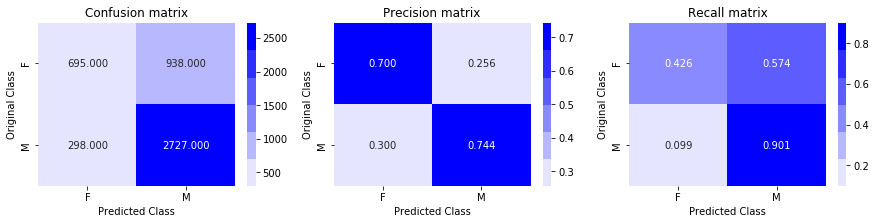

In [94]:
events_model_rf = "Events - Random Forest"

n_estimator = [100,200,500,1000,2000]
max_depth = [5, 10]

hp = [n_estimator, max_depth]

events_acc_rf, events_auc_rf, events_logloss_rf = hyperparameter_tuning("rf", hp, "n_estimator, max_depth", events_x_train, events_y_train, events_x_cv, events_y_cv, events_x_test, events_y_test)

## XGBoost Model

Fitting 2 folds for each of 30 candidates, totalling 60 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  3.0min
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:  6.4min finished


The test log loss is: 0.5070646712882384
Percentage of missclassified point : 0.24431086303134392
Accuracy:  75.56891369686561
AUC:  0.8048699093591373


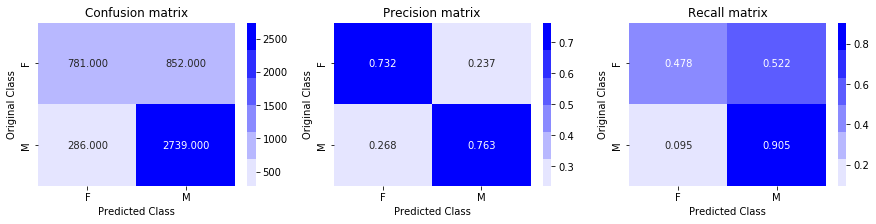

In [95]:
events_model_xgb = "Events - XGBoost"

params = {
         'eval_metric':['logloss'],
         'eta':[0.02, 0.01, 0.1, 0.5],
         'max_depth':[4,6,8,10],
         'n_estimators':[5,10,20,50,100]
         }

clf = xgb.XGBClassifier(objective='binary:logistic')

x = vstack((events_x_train, events_x_cv))
y = np.concatenate([events_y_train, events_y_cv])

#trying out 30 possible combinations of hyperparameters
rs_clf = RandomizedSearchCV(clf, params, verbose = 2, cv = 2, n_iter = 30, n_jobs = 8)
rs_clf.fit(x,y)

best_clf = rs_clf.best_estimator_

predict_y_proba = best_clf.predict_proba(events_x_test)
predict_y = best_clf.predict(events_x_test)
events_logloss_xgb = log_loss(events_y_test, predict_y_proba, labels=best_clf.classes_, eps=1e-15)
print("The test log loss is:",events_logloss_xgb)

mp = np.count_nonzero((predict_y- events_y_test))/events_y_test.shape[0]
print("Percentage of missclassified point :", mp)

events_acc_xgb = (1-mp)*100
print("Accuracy: ", events_acc_xgb)

events_auc_xgb = roc_auc_score(events_y_test, predict_y_proba[:,1])
print("AUC: ", events_auc_xgb) 

plot_confusion_matrix(events_y_test, predict_y)

## Results for records with events

In [97]:
#summarizing results
table = PrettyTable()

table.field_names = ["Model", "Accuracy", "AUC", "LogLoss"]

table.add_row([events_model_rand, events_acc_rand, events_auc_rand, events_logloss_rand])
table.add_row([events_model_lrb, events_acc_lrb, events_auc_lrb, events_logloss_lrb])
table.add_row([events_model_svm, events_acc_svm, events_auc_svm, events_logloss_svm])
table.add_row([events_model_rf, events_acc_rf, events_auc_rf, events_logloss_rf])
table.add_row([events_model_xgb, events_acc_xgb, events_auc_xgb, events_logloss_xgb])

print(table)

+---------------------------------------+--------------------+--------------------+--------------------+
|                 Model                 |      Accuracy      |        AUC         |      LogLoss       |
+---------------------------------------+--------------------+--------------------+--------------------+
|         Events - Random Model         | 49.914126234435386 | 0.5012614819350888 | 0.8880323659542394 |
| Events - Logistic Regression Balanced | 73.91584370974667  | 0.7872894282692201 | 0.5280133257535259 |
|    Events - Support Vector Machines   | 74.30227565478746  | 0.7912219562433892 | 0.5257974960513053 |
|         Events - Random Forest        | 73.46500644053242  | 0.771511338964437  | 0.5392773748238496 |
|            Events - XGBoost           | 75.56891369686561  | 0.8048699093591373 | 0.5070646712882384 |
+---------------------------------------+--------------------+--------------------+--------------------+


## Including device specifications

In [98]:
scaler = StandardScaler()

In [99]:
events_screen_train = scaler.fit_transform(df_events_train['screen_size'].values.reshape(-1,1))
events_screen_cv = scaler.transform(df_events_cv['screen_size'].values.reshape(-1,1))
events_screen_test = scaler.transform(df_events_test['screen_size'].values.reshape(-1,1))

In [100]:
events_ram_train = scaler.fit_transform(df_events_train['ram_gb'].values.reshape(-1,1))
events_ram_cv = scaler.transform(df_events_cv['ram_gb'].values.reshape(-1,1))
events_ram_test = scaler.transform(df_events_test['ram_gb'].values.reshape(-1,1))

In [101]:
events_camera_train = scaler.fit_transform(df_events_train['camera'].values.reshape(-1,1))
events_camera_cv = scaler.transform(df_events_cv['camera'].values.reshape(-1,1))
events_camera_test = scaler.transform(df_events_test['camera'].values.reshape(-1,1))

In [102]:
events_release_train = scaler.fit_transform(df_events_train['release_bin'].values.reshape(-1,1))
events_release_cv = scaler.transform(df_events_cv['release_bin'].values.reshape(-1,1))
events_release_test = scaler.transform(df_events_test['release_bin'].values.reshape(-1,1))

In [103]:
events_x_train = hstack((events_brand_train, events_model_train, events_installed_labels_train, events_active_labels_train,
                         events_lat_train, events_long_train, events_travels_train, df_events_train['location_available'].values.reshape(-1,1), 
                         np.array(df_events_train['activity_hour'].to_list()), np.array(df_events_train['activity_day'].to_list()), 
                         df_events_train['app_usage'].values.reshape(-1,1), df_events_train['app_usage_session'].values.reshape(-1,1), 
                         np.array(df_events_train['installed_app_counts'].to_list()), np.array(df_events_train['active_app_usage_counts'].to_list()), 
                         np.array(df_events_train['active_app_usage'].to_list()), events_screen_train, events_ram_train,
                         events_camera_train, events_release_train, df_events_train['specs_available'].values.reshape(-1,1)))

In [104]:
events_x_cv = hstack((events_brand_cv, events_model_cv, events_installed_labels_cv, events_active_labels_cv,
                         events_lat_cv, events_long_cv, events_travels_cv, df_events_cv['location_available'].values.reshape(-1,1), 
                         np.array(df_events_cv['activity_hour'].to_list()), np.array(df_events_cv['activity_day'].to_list()), 
                         df_events_cv['app_usage'].values.reshape(-1,1), df_events_cv['app_usage_session'].values.reshape(-1,1), 
                         np.array(df_events_cv['installed_app_counts'].to_list()), np.array(df_events_cv['active_app_usage_counts'].to_list()), 
                         np.array(df_events_cv['active_app_usage'].to_list()), events_screen_cv, events_ram_cv,
                         events_camera_cv, events_release_cv, df_events_cv['specs_available'].values.reshape(-1,1)))

In [106]:
events_x_test = hstack((events_brand_test, events_model_test, events_installed_labels_test, events_active_labels_test,
                         events_lat_test, events_long_test, events_travels_test, df_events_test['location_available'].values.reshape(-1,1), 
                         np.array(df_events_test['activity_hour'].to_list()), np.array(df_events_test['activity_day'].to_list()), 
                         df_events_test['app_usage'].values.reshape(-1,1), df_events_test['app_usage_session'].values.reshape(-1,1), 
                         np.array(df_events_test['installed_app_counts'].to_list()), np.array(df_events_test['active_app_usage_counts'].to_list()), 
                         np.array(df_events_test['active_app_usage'].to_list()), events_screen_test, events_ram_test,
                         events_camera_test, events_release_test, df_events_test['specs_available'].values.reshape(-1,1)))

## Logistic Regression Model with Balanced Class Weights

for alpha = 1e-06
Log Loss : 0.5887362909388626
for alpha = 1e-05
Log Loss : 0.5754005040206249
for alpha = 0.0001
Log Loss : 0.5471162285060095
for alpha = 0.001
Log Loss : 0.5471682956081951
for alpha = 0.01
Log Loss : 0.56321437461823
for alpha = 0.1
Log Loss : 0.594480391852629
for alpha = 1
Log Loss : 0.6199917689004909
for alpha = 10
Log Loss : 0.6260919378861914
for alpha = 100
Log Loss : 0.6268106742650358
For values of best  alpha  =  0.0001 The train log loss is: 0.4831802591963152
For values of best  alpha  =  0.0001 The cross validation log loss is: 0.5471162285060095
For values of best  alpha  =  0.0001 The test log loss is: 0.5320284559132478
Percentage of missclassified points : 0.2606268784886217
Accuracy:  73.93731215113783
AUC:  0.7854409822210302


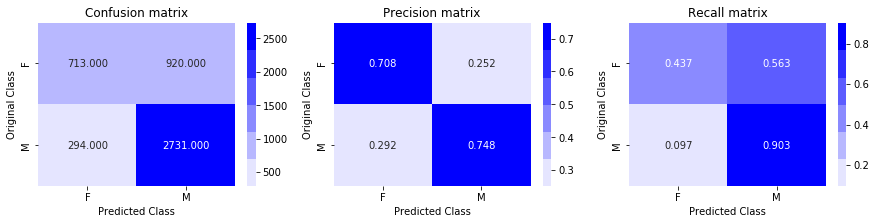

In [107]:
events_model_lrb = "Events - Logistic Regression Balanced"

alpha = [10 ** x for x in range(-6, 3)]

events_acc_lrb, events_auc_lrb, events_logloss_lrb = hyperparameter_tuning("lrb", alpha, "alpha", events_x_train, events_y_train, events_x_cv, events_y_cv, events_x_test, events_y_test)

## Support Vector Machines Model

for c = 1e-05
Log Loss : 0.5719316270605944
for c = 0.0001
Log Loss : 0.5511410286781205
for c = 0.001
Log Loss : 0.5460000044675664
for c = 0.01
Log Loss : 0.56053356258665
for c = 0.1
Log Loss : 0.6011824885463206
for c = 1
Log Loss : 0.6269295840381267
for c = 10
Log Loss : 0.6269327868450224
for c = 100
Log Loss : 0.6269331772119171
For values of best  c  =  0.001 The train log loss is: 0.4967812922277764
For values of best  c  =  0.001 The cross validation log loss is: 0.5460000044675664
For values of best  c  =  0.001 The test log loss is: 0.5259249157769489
Percentage of missclassified points : 0.25805066552168315
Accuracy:  74.19493344783167
AUC:  0.7912472607835297


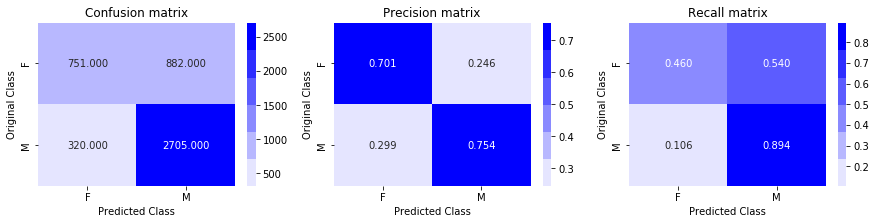

In [108]:
events_model_svm = "Events - Support Vector Machines"

c = [10 ** x for x in range(-5, 3)]

events_acc_svm, events_auc_svm, events_logloss_svm = hyperparameter_tuning("svm", c, "c", events_x_train, events_y_train, events_x_cv, events_y_cv, events_x_test, events_y_test)

## Random Forest Model

for n_estimators = 100, max_depth = 5
Log Loss : 0.566586130821141
for n_estimators = 100, max_depth = 10
Log Loss : 0.5516383041832267
for n_estimators = 200, max_depth = 5
Log Loss : 0.5665157348190104
for n_estimators = 200, max_depth = 10
Log Loss : 0.5512540683279573
for n_estimators = 500, max_depth = 5
Log Loss : 0.5662015073407826
for n_estimators = 500, max_depth = 10
Log Loss : 0.5512909540441254
for n_estimators = 1000, max_depth = 5
Log Loss : 0.5663330022964311
for n_estimators = 1000, max_depth = 10
Log Loss : 0.5512376519778429
for n_estimators = 2000, max_depth = 5
Log Loss : 0.5660149593243409
for n_estimators = 2000, max_depth = 10
Log Loss : 0.5512825793571999
For values of best  n_estimator, max_depth  =  (1000, 10) The train log loss is: 0.425249086719289
For values of best  n_estimator, max_depth  =  (1000, 10) The cross validation log loss is: 0.5512376519778429
For values of best  n_estimator, max_depth  =  (1000, 10) The test log loss is: 0.5397134083553882
Per

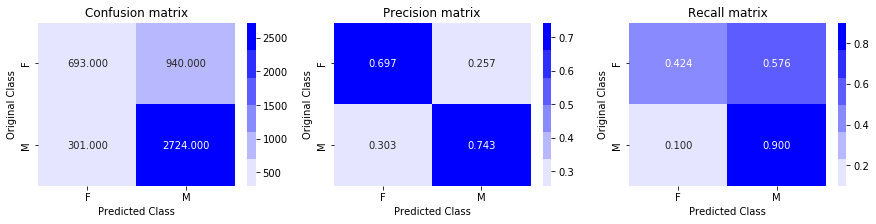

In [109]:
events_model_rf = "Events - Random Forest"

n_estimator = [100,200,500,1000,2000]
max_depth = [5, 10]

hp = [n_estimator, max_depth]

events_acc_rf, events_auc_rf, events_logloss_rf = hyperparameter_tuning("rf", hp, "n_estimator, max_depth", events_x_train, events_y_train, events_x_cv, events_y_cv, events_x_test, events_y_test)

## XGBoost Model

Fitting 2 folds for each of 30 candidates, totalling 60 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:  4.6min finished


The test log loss is: 0.5121644688478262
Percentage of missclassified point : 0.24924860455130957
Accuracy:  75.07513954486905
AUC:  0.8015356819320523


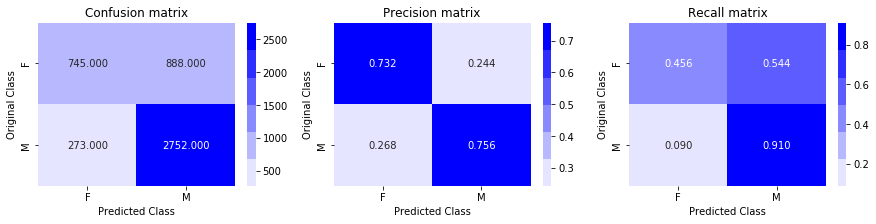

In [110]:
events_model_xgb = "Events - XGBoost"

params = {
         'eval_metric':['logloss'],
         'eta':[0.02, 0.01, 0.1, 0.5],
         'max_depth':[4,6,8,10],
         'n_estimators':[5,10,20,50,100]
         }

clf = xgb.XGBClassifier(objective='binary:logistic')

x = vstack((events_x_train, events_x_cv))
y = np.concatenate([events_y_train, events_y_cv])

#trying out 30 possible combinations of hyperparameters
rs_clf = RandomizedSearchCV(clf, params, verbose = 2, cv = 2, n_iter = 30, n_jobs = 8)
rs_clf.fit(x,y)

best_clf = rs_clf.best_estimator_

predict_y_proba = best_clf.predict_proba(events_x_test)
predict_y = best_clf.predict(events_x_test)
events_logloss_xgb = log_loss(events_y_test, predict_y_proba, labels=best_clf.classes_, eps=1e-15)
print("The test log loss is:",events_logloss_xgb)

mp = np.count_nonzero((predict_y- events_y_test))/events_y_test.shape[0]
print("Percentage of missclassified point :", mp)

events_acc_xgb = (1-mp)*100
print("Accuracy: ", events_acc_xgb)

events_auc_xgb = roc_auc_score(events_y_test, predict_y_proba[:,1])
print("AUC: ", events_auc_xgb) 

plot_confusion_matrix(events_y_test, predict_y)

## Results for records with events

In [111]:
#summarizing results
table = PrettyTable()

table.field_names = ["Model", "Accuracy", "AUC", "LogLoss"]

table.add_row([events_model_rand, events_acc_rand, events_auc_rand, events_logloss_rand])
table.add_row([events_model_lrb, events_acc_lrb, events_auc_lrb, events_logloss_lrb])
table.add_row([events_model_svm, events_acc_svm, events_auc_svm, events_logloss_svm])
table.add_row([events_model_rf, events_acc_rf, events_auc_rf, events_logloss_rf])
table.add_row([events_model_xgb, events_acc_xgb, events_auc_xgb, events_logloss_xgb])

print(table)

+---------------------------------------+--------------------+--------------------+--------------------+
|                 Model                 |      Accuracy      |        AUC         |      LogLoss       |
+---------------------------------------+--------------------+--------------------+--------------------+
|         Events - Random Model         | 49.914126234435386 | 0.5012614819350888 | 0.8880323659542394 |
| Events - Logistic Regression Balanced | 73.93731215113783  | 0.7854409822210302 | 0.5320284559132478 |
|    Events - Support Vector Machines   | 74.19493344783167  | 0.7912472607835297 | 0.5259249157769489 |
|         Events - Random Forest        | 73.35766423357664  | 0.7709947214729266 | 0.5397134083553882 |
|            Events - XGBoost           | 75.07513954486905  | 0.8015356819320523 | 0.5121644688478262 |
+---------------------------------------+--------------------+--------------------+--------------------+


## Adding Gender Predictions as a feature

In [112]:
noevents_x_train = hstack((noevents_brand_train, noevents_model_train))
noevents_x_cv = hstack((noevents_brand_cv, noevents_model_cv))
noevents_x_test = hstack((noevents_brand_test, noevents_model_test))

In [118]:
noevents_model_xgb = "No Events - XGBoost"

params = {
         'eval_metric':['logloss'],
         'eta':[0.02, 0.01, 0.1, 0.5],
         'max_depth':[4,6,8,10],
         'n_estimators':[5,10,20,50,100]
         }

clf = xgb.XGBClassifier(objective='binary:logistic')

x = vstack((noevents_x_train, noevents_x_cv))
y = np.concatenate([noevents_y_train, noevents_y_cv])

#trying out 30 possible combinations of hyperparameters
rs_clf = RandomizedSearchCV(clf, params, verbose = 2, cv = 2, n_iter = 30, n_jobs = 8)
rs_clf.fit(x,y)

noevents_best_clf = rs_clf.best_estimator_

predict_y_proba = noevents_best_clf.predict_proba(noevents_x_test)
predict_y = noevents_best_clf.predict(noevents_x_test)
noevents_logloss_xgb = log_loss(noevents_y_test, predict_y_proba, labels=best_clf.classes_, eps=1e-15)
print("The test log loss is:",noevents_logloss_xgb)

mp = np.count_nonzero((predict_y- noevents_y_test))/noevents_y_test.shape[0]
print("Percentage of missclassified point :", mp)

noevents_acc_xgb = (1-mp)*100
print("Accuracy: ", noevents_acc_xgb)

noevents_auc_xgb = roc_auc_score(noevents_y_test, predict_y_proba[:,1])
print("AUC: ", noevents_auc_xgb)

Fitting 2 folds for each of 30 candidates, totalling 60 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:    7.0s finished


The test log loss is: 0.6504839752632924
Percentage of missclassified point : 0.35351961834290724
Accuracy:  64.64803816570928
AUC:  0.5720669259389122


In [114]:
events_x_train = hstack((events_brand_train, events_model_train, events_installed_labels_train, events_active_labels_train,
                         events_lat_train, events_long_train, events_travels_train, df_events_train['location_available'].values.reshape(-1,1), 
                         np.array(df_events_train['activity_hour'].to_list()), np.array(df_events_train['activity_day'].to_list()), 
                         df_events_train['app_usage'].values.reshape(-1,1), df_events_train['app_usage_session'].values.reshape(-1,1), 
                         np.array(df_events_train['installed_app_counts'].to_list()), np.array(df_events_train['active_app_usage_counts'].to_list()), 
                         np.array(df_events_train['active_app_usage'].to_list())))

In [115]:
events_x_cv = hstack((events_brand_cv, events_model_cv, events_installed_labels_cv, events_active_labels_cv,
                         events_lat_cv, events_long_cv, events_travels_cv, df_events_cv['location_available'].values.reshape(-1,1), 
                         np.array(df_events_cv['activity_hour'].to_list()), np.array(df_events_cv['activity_day'].to_list()), 
                         df_events_cv['app_usage'].values.reshape(-1,1), df_events_cv['app_usage_session'].values.reshape(-1,1), 
                         np.array(df_events_cv['installed_app_counts'].to_list()), np.array(df_events_cv['active_app_usage_counts'].to_list()), 
                         np.array(df_events_cv['active_app_usage'].to_list())))

In [116]:
events_x_test = hstack((events_brand_test, events_model_test, events_installed_labels_test, events_active_labels_test,
                         events_lat_test, events_long_test, events_travels_test, df_events_test['location_available'].values.reshape(-1,1), 
                         np.array(df_events_test['activity_hour'].to_list()), np.array(df_events_test['activity_day'].to_list()), 
                         df_events_test['app_usage'].values.reshape(-1,1), df_events_test['app_usage_session'].values.reshape(-1,1), 
                         np.array(df_events_test['installed_app_counts'].to_list()), np.array(df_events_test['active_app_usage_counts'].to_list()), 
                         np.array(df_events_test['active_app_usage'].to_list())))

In [119]:
events_model_xgb = "Events - XGBoost"

params = {
         'eval_metric':['logloss'],
         'eta':[0.02, 0.01, 0.1, 0.5],
         'max_depth':[4,6,8,10],
         'n_estimators':[5,10,20,50,100]
         }

clf = xgb.XGBClassifier(objective='binary:logistic')

x = vstack((events_x_train, events_x_cv))
y = np.concatenate([events_y_train, events_y_cv])

#trying out 30 possible combinations of hyperparameters
rs_clf = RandomizedSearchCV(clf, params, verbose = 2, cv = 2, n_iter = 30, n_jobs = 8)
rs_clf.fit(x,y)

events_best_clf = rs_clf.best_estimator_

predict_y_proba = events_best_clf.predict_proba(events_x_test)
predict_y = events_best_clf.predict(events_x_test)
events_logloss_xgb = log_loss(events_y_test, predict_y_proba, labels=best_clf.classes_, eps=1e-15)
print("The test log loss is:",events_logloss_xgb)

mp = np.count_nonzero((predict_y- events_y_test))/events_y_test.shape[0]
print("Percentage of missclassified point :", mp)

events_acc_xgb = (1-mp)*100
print("Accuracy: ", events_acc_xgb)

events_auc_xgb = roc_auc_score(events_y_test, predict_y_proba[:,1])
print("AUC: ", events_auc_xgb) 

Fitting 2 folds for each of 30 candidates, totalling 60 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.7min
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:  6.6min finished


The test log loss is: 0.5070646712882384
Percentage of missclassified point : 0.24431086303134392
Accuracy:  75.56891369686561
AUC:  0.8048699093591373


In [146]:
df_train_noevents = pd.read_pickle("dataset/dataset_train_noevents.pkl")
df_train_events = pd.read_pickle("dataset/dataset_train_events.pkl")
df_test_noevents = pd.read_pickle("dataset/dataset_test_noevents.pkl")

In [147]:
df1 = pd.read_pickle("dataset_test_events1.pkl")
df2 = pd.read_pickle("dataset_test_events2.pkl")
df3 = pd.read_pickle("dataset_test_events3.pkl")
df4 = pd.read_pickle("dataset_test_events4.pkl")
df5 = pd.read_pickle("dataset_test_events5.pkl")
df6 = pd.read_pickle("dataset_test_events6.pkl")
df7 = pd.read_pickle("dataset_test_events7.pkl")
df8 = pd.read_pickle("dataset_test_events8.pkl")
df9 = pd.read_pickle("dataset_test_events9.pkl")
df10 = pd.read_pickle("dataset_test_events10.pkl")

In [148]:
df_test_events = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10])

In [149]:
df_train_events.loc[df_train_events['app_usage'].isna(),'app_usage']=0
df_train_events.loc[df_train_events['app_usage_session'].isna(),'app_usage_session']=0

In [150]:
df_test_events.loc[df_test_events['app_usage'].isna(),'app_usage']=0
df_test_events.loc[df_test_events['app_usage_session'].isna(),'app_usage_session']=0

### No Events

In [151]:
noevents_brand_train = noevents_brand_encoder.transform(df_train_noevents['brand'])
noevents_brand_test = noevents_brand_encoder.transform(df_test_noevents['brand'])

In [152]:
noevents_model_train = noevents_model_encoder.transform(df_train_noevents['model'])
noevents_model_test = noevents_model_encoder.transform(df_test_noevents['model'])

In [153]:
noevents_x_train = hstack((noevents_brand_train, noevents_model_train))
noevents_x_test = hstack((noevents_brand_test, noevents_model_test))

In [154]:
gender_pred_train = noevents_best_clf.predict_proba(noevents_x_train)
gender_pred_test = noevents_best_clf.predict_proba(noevents_x_test)

In [164]:
print(df_train_noevents.columns)

Index(['device_id', 'brand', 'model', 'gender', 'age', 'group', 'screen_size',
       'ram_gb', 'release_month', 'release_year', 'camera', 'specs_available'],
      dtype='object')


In [165]:
df_train_noevents['female_pred'] = gender_pred_train[:,0]
df_train_noevents['male_pred'] = gender_pred_train[:,1]

In [167]:
df_test_noevents['female_pred'] = gender_pred_test[:,0]
df_test_noevents['male_pred'] = gender_pred_test[:,1]

### Events

In [169]:
events_brand_train = events_brand_encoder.transform(df_train_events['brand'])
events_brand_test = events_brand_encoder.transform(df_test_events['brand'])

In [168]:
events_model_train = events_model_encoder.transform(df_train_events['model'])
events_model_test = events_model_encoder.transform(df_test_events['model'])

In [170]:
events_active_labels_train = events_active_labels_encoder.transform(df_train_events['active_app_labels'])
events_active_labels_test = events_active_labels_encoder.transform(df_test_events['active_app_labels'])

In [171]:
events_installed_labels_train = events_installed_labels_encoder.transform(df_train_events['installed_app_labels'])
events_installed_labels_test = events_installed_labels_encoder.transform(df_test_events['installed_app_labels'])

In [172]:
scaler = StandardScaler()

In [173]:
events_lat_train = scaler.fit_transform(df_train_events['mean_latitude'].values.reshape(-1,1))
events_lat_test = scaler.transform(df_test_events['mean_latitude'].values.reshape(-1,1))

In [174]:
events_long_train = scaler.fit_transform(df_train_events['mean_longitude'].values.reshape(-1,1))
events_long_test = scaler.transform(df_test_events['mean_longitude'].values.reshape(-1,1))

In [175]:
events_travels_train = scaler.fit_transform(df_train_events['num_travels'].values.reshape(-1,1))
events_travels_test = scaler.transform(df_test_events['num_travels'].values.reshape(-1,1))

In [176]:
events_x_train = hstack((events_brand_train, events_model_train, events_installed_labels_train, events_active_labels_train,
                         events_lat_train, events_long_train, events_travels_train, df_train_events['location_available'].values.reshape(-1,1), 
                         np.array(df_train_events['activity_hour'].to_list()), np.array(df_train_events['activity_day'].to_list()), 
                         df_train_events['app_usage'].values.reshape(-1,1), df_train_events['app_usage_session'].values.reshape(-1,1), 
                         np.array(df_train_events['installed_app_counts'].to_list()), np.array(df_train_events['active_app_usage_counts'].to_list()), 
                         np.array(df_train_events['active_app_usage'].to_list())))

In [177]:
events_x_test = hstack((events_brand_test, events_model_test, events_installed_labels_test, events_active_labels_test,
                         events_lat_test, events_long_test, events_travels_test, df_test_events['location_available'].values.reshape(-1,1), 
                         np.array(df_test_events['activity_hour'].to_list()), np.array(df_test_events['activity_day'].to_list()), 
                         df_test_events['app_usage'].values.reshape(-1,1), df_test_events['app_usage_session'].values.reshape(-1,1), 
                         np.array(df_test_events['installed_app_counts'].to_list()), np.array(df_test_events['active_app_usage_counts'].to_list()), 
                         np.array(df_test_events['active_app_usage'].to_list())))

In [179]:
gender_pred_train = events_best_clf.predict_proba(events_x_train)
gender_pred_test = events_best_clf.predict_proba(events_x_test)

In [180]:
df_train_events['female_pred'] = gender_pred_train[:,0]
df_train_events['male_pred'] = gender_pred_train[:,1]

In [181]:
df_test_events['female_pred'] = gender_pred_test[:,0]
df_test_events['male_pred'] = gender_pred_test[:,1]

In [185]:
print(df_train_noevents.columns, df_test_noevents.columns, df_train_events.columns, df_test_events.columns)

Index(['device_id', 'brand', 'model', 'gender', 'age', 'group', 'screen_size',
       'ram_gb', 'release_month', 'release_year', 'camera', 'specs_available',
       'female_pred', 'male_pred'],
      dtype='object') Index(['device_id', 'brand', 'model', 'screen_size', 'ram_gb', 'release_month',
       'release_year', 'camera', 'specs_available', 'female_pred',
       'male_pred'],
      dtype='object') Index(['device_id', 'brand', 'model', 'gender', 'age', 'group', 'app_usage',
       'app_usage_session', 'active_app_usage_counts', 'activity_hour',
       'activity_day', 'num_travels', 'mean_latitude', 'mean_longitude',
       'screen_size', 'ram_gb', 'release_month', 'release_year', 'camera',
       'installed_app_labels', 'active_app_labels', 'installed_app_counts',
       'active_app_usage', 'location_available', 'specs_available',
       'female_pred', 'male_pred'],
      dtype='object') Index(['device_id', 'brand', 'model', 'app_usage', 'app_usage_session',
       'active_app_usag

In [183]:
df_train_noevents.to_pickle("dataset/gender_predictions/df_train_noevents.pkl")
df_train_events.to_pickle("dataset/gender_predictions/df_train_events.pkl")
df_test_noevents.to_pickle("dataset/gender_predictions/df_test_noevents.pkl")
df_test_events.to_pickle("dataset/gender_predictions/df_test_events.pkl")